# Classification Of Brain Tumors - Model Creation and Evaluation

This notebook is the 4th Step in creating a working model for Brain Tumor Classification Problem and lists down the following:

1. Create 2-3 different Models using CNN for your Train data and then Evaluate them on the Test Data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step-0: Installing the required libraries

In [2]:
#Installing Keras
! pip install Keras

In [3]:
#Installing Tensorflow
! pip install tensorflow

## Step-1: Loading the data into Dataframes

In [1]:
#load required python packages
import os
import shutil
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import plot_model
%matplotlib inline

In [2]:
#Print the current working directory
path = "drive/MyDrive/Data"
print(path)

drive/MyDrive/Data


In [3]:
#Create 2 new Path variables so that they point to 'Train' and 'Test' Directories
train_path = os.path.join(path,'Train')
test_path = os.path.join(path,'Test')
predict_path = os.path.join(path,'Prediction Images')

## Step-2: Creating 2nd Model- Inception v1

In [7]:
#Reading Images & Loading the image data from Train & Tests folder into a Dataframes
train = ImageDataGenerator()
train_df = train.flow_from_directory(train_path, target_size = (150,150))
test = ImageDataGenerator()
test_df = train.flow_from_directory(test_path, target_size = (150,150))

Found 2821 images belonging to 2 classes.
Found 704 images belonging to 2 classes.


### Create a function for Inception block and Adding the below layers in the given order

1. Convolution Layer of f1 channels of 1x1 kernal and same padding.
2. Convolution Layer of f2 channels of 3x3 kernal and same padding.
3. Convolution Layer of f3 channels of 5x5 kernal and same padding.
4. Maxpool layer of 3x3 pool size and stride 1x1.
5. Concatenate all the above layers.

Each of these layers have a ReLu Activation as well so that negative values are not passed to the next layer.

In [8]:
#Creating a Function for Inception Block
def inception(layer_in):
    conv1 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_in)
    conv1 = Conv2D(10, (3,3), padding='same', activation='relu')(conv1)

    conv5 = Conv2D(10, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(10, (5,5), padding='same', activation='relu')(conv5)
    
    pool = MaxPool2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(10, (1,1), padding='same', activation='relu')(pool)
    layer_out = concatenate([conv1, conv5, pool], axis=3)
    return layer_out

In [9]:
# define model input
visible = Input(shape=(150, 150, 3))
# add inception module
layer = inception(visible)
#Flattening the layers
flat_1 = Flatten()(layer)
dense_2 = Dense(600, activation='relu')(flat_1)
dense_3 = Dense(150, activation='relu')(dense_2)
output = Dense(2, activation='softmax')(dense_3)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 10) 40          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 150, 150, 10) 40          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 150, 150, 3)  0           input_1[0][0]                    
_______________________________________________________________________________________

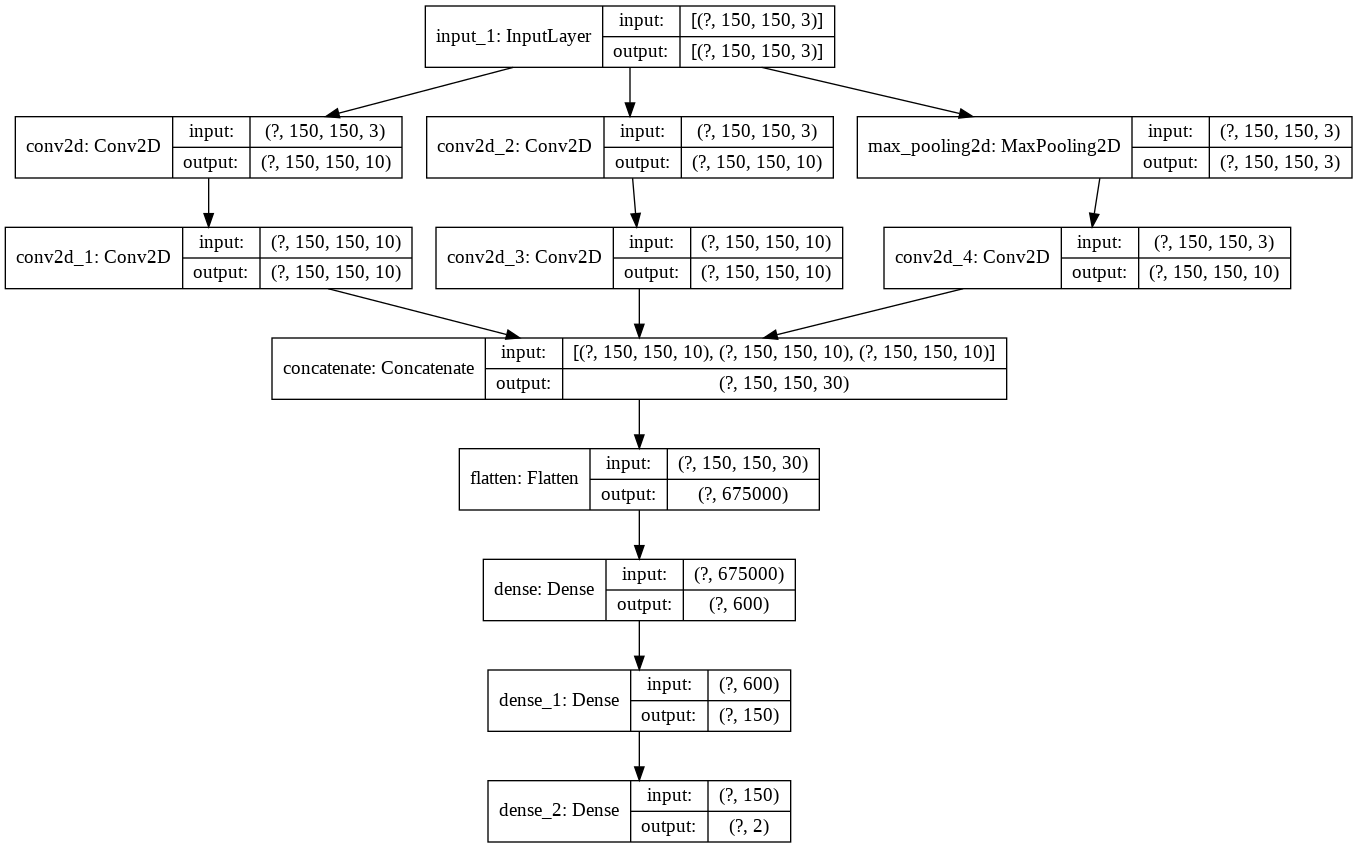

In [10]:
# create model
incep = Model([visible], output)
#Compiling the created Model.
incep.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
# summarize model
incep.summary()
# plot model architecture
plot_model(incep, show_shapes=True, to_file='inception.png')

In [11]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_2 = ModelCheckpoint("inception_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
early_2 = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
hist_2 = incep.fit_generator(steps_per_epoch=50,generator=train_df, validation_data= test_df, validation_steps=10,epochs=50,callbacks=[checkpoint_2,early_2])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: 546.8133 - accuracy: 0.7237 
Epoch 00001: val_accuracy improved from -inf to 0.85000, saving model to inception_1.h5
50/50 [==============================] - 964s 19s/step - loss: 546.8133 - accuracy: 0.7237 - val_loss: 118.1802 - val_accuracy: 0.8500
Epoch 2/50
50/50 [==============================] - ETA: 0s - loss: 67.2729 - accuracy: 0.8417
Epoch 00002: val_accuracy improved from 0.85000 to 0.90000, saving model to inception_1.h5
50/50 [==============================] - 467s 9s/step - loss: 67.2729 - accuracy: 0.8417 - val_loss: 42.5822 - val_accuracy: 0.9000
Epoch 3/50
50/50 [==============================] - ETA: 0s - loss: 20.5497 - accuracy: 0.9019
Epoch 00003: val_accuracy did not improve from 0.90000
50/50 [==============================] - 292s 6s/step - loss: 20.5497 - accuracy: 0.9019 - val_loss: 37.5612 - val_accuracy: 0.8844
Epoc

### Lets plot the Accuracy with each Epoch

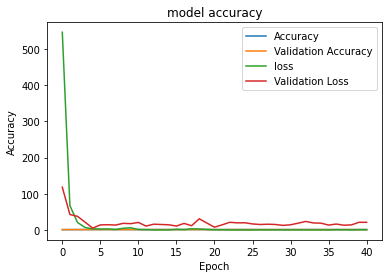

In [12]:
plt.plot(hist_2.history["accuracy"])
plt.plot(hist_2.history['val_accuracy'])
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Thus, after training, our model has an Accuracy of 96.25%

### Lets load the best saved model and then make our predictions using Prediction Images.

In [4]:
#Loading our saved model
from keras.models import load_model
inception = load_model("inception_1.h5")

#Making Predictions
pred = {}
for fl in listdir(os.path.join(predict_path,'Yes')):    
    img = image.load_img(os.path.join(predict_path,'Yes',fl))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = inception.predict(img)
    if(output[0][0] > output[0][1]):
        pred[fl] = 'N'
    else:
        pred[fl] = 'Y'
for fl in listdir(os.path.join(predict_path,'No')):    
    img = image.load_img(os.path.join(predict_path,'No',fl))
    img = np.asarray(img)
    img = np.expand_dims(img, axis=0)
    output = inception.predict(img)
    if(output[0][0] > output[0][1]):
        pred[fl] = 'Y'
    else:
        pred[fl] = 'N'
print(pred)

{'Y_10.JPG': 'Y', 'Y_16.JPG': 'Y', 'Y_19.JPG': 'Y', 'Y_1.JPG': 'Y', 'Y_5.JPG': 'Y', 'Y_14.JPG': 'Y', 'Y_13.JPG': 'Y', 'Y_18.JPG': 'Y', 'Y_8.JPG': 'Y', 'Y_9.JPG': 'Y', 'Y_7.JPG': 'Y', 'Y_15.JPG': 'Y', 'Y_20.JPG': 'Y', 'Y_12.JPG': 'Y', 'Y_2.JPG': 'N', 'Y_11.JPG': 'Y', 'Y_17.JPG': 'N', 'Y_6.JPG': 'Y', 'Y_3.JPG': 'Y', 'Y_4.JPG': 'Y', 'N_10.JPG': 'N', 'N_13.JPG': 'N', 'N_12.JPG': 'N', 'N_18.JPG': 'N', 'N_16.JPG': 'N', 'N_15.JPG': 'N', 'N_17.JPG': 'N', 'N_14.JPG': 'N', 'N_1.JPG': 'N', 'N_11.JPG': 'N', 'N_6.JPG': 'N', 'N_5.JPG': 'N', 'N_20.JPG': 'N', 'N_2.JPG': 'N', 'N_8.JPG': 'N', 'N_3.JPG': 'N', 'N_7.JPG': 'N', 'N_9.JPG': 'N', 'N_4.JPG': 'N', 'N_19.JPG': 'N'}


In [5]:
# Counting the Images classified Correctly and Incorrectly.
correct = 0
wrong = 0
for key,val in pred.items():
    if(key[0] == val):
        correct += 1
    else:
        wrong += 1
print("Correct Classification: " + str(correct))
print("Incorrect Classification: " + str(wrong))

Correct Classification: 38
Incorrect Classification: 2


## Thus, it looks like Our created model was able to classify 38/40 Images for prediction Correctly.